# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Признаки:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

 # План работы

1. Загрузка и подготовка данных.
2. Обучение и проверка модель для каждого региона:
 - Разбиение данных на обучающую и валидационную выборки в соотношении 75:25.
 - Обучение модели и получение предсказания на валидационной выборке.
 - Сохранение предсказания и правильных ответов на валидационной выборке.
 - Расчет среднего запаса предсказанного сырья и RMSE модели.
 - Анализ результатов.
3. Подготовка к расчёту прибыли:
 - Сохранение всех ключевых значений для расчётов в отдельных переменных.
 - Рассчет достаточного объём сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе.
 - Выводы по этапу подготовки расчёта прибыли.
4. Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - Выбор скважины с максимальными значениями предсказаний.
 - Суммирование целевого значение объёма сырья, соответствующее этим предсказаниям.
 - Рассчет прибыли для полученного объёма сырья.
5. Расчет рисков и прибыли для каждого региона:
 - Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - Расчет средней прибыли, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - Выводы: выбор региона для разработки скважин и обоснование выбора.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
display(data_0.head(5))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(data_1.head(5))

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
display(data_2.head(5))

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Удалим столбец ID, так как данные в данном столбце не оказывают влияние на целевой признак.

In [10]:
data_0= data_0.drop(columns=['id'], axis=1)

In [11]:
data_1= data_1.drop(columns=['id'], axis=1)

In [12]:
data_2= data_2.drop(columns=['id'], axis=1)

Посмотрим на численные данные оставшиеся в таблице

In [13]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [14]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [15]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Промежуточный вывод:
 1. В загруженных данных были удалены столбцы ID для всех регионов как невлияющий на целевой признак.
 2. При рассмотрении данных было устанволено, что целевой признак product имеет очень большой разброс:
  - 1-й регион: среднее 92.5, min=0, max=185;
  - 2-й регион: среднее 69, min=0, max=137;
  - 3-й регион: среднее 95, min=0, max=190.
 3. При дальнешем определении региона и поиске лучших скважин нужно учитвывать, что отклонение от среднего в большую и меньшую сторону достаточно большое. 

## Обучение и проверка модели

### Разбиение данных на обучающую и валидационную выборки в соотношении 75:25

Создадим функцию для деления выборки на обучающущю и валидационную.

In [16]:
# функция деления выборки
def separate(data):
    target = data['product']
    features = data.drop('product', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

#### 1-й регион

In [17]:
# применим функцию деления на выборки для 1-го региона
features_train_0, features_valid_0, target_train_0, target_valid_0 = separate(data_0)

In [18]:
#check
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


#### 2-й регион

In [19]:
# применим функцию деления на выборки для 2-го региона
features_train_1, features_valid_1, target_train_1, target_valid_1 = separate(data_1)

In [20]:
#check
print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


#### 3-й регион

In [21]:
# применим функцию деления на выборки для 3-го региона
features_train_2, features_valid_2, target_train_2, target_valid_2 = separate(data_2)

In [22]:
#check
print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [23]:
# check
type(target_valid_2)

pandas.core.series.Series

### Обучение модели и получение предсказания на валидационной выборке.

Создадим функцию для получения предсказаний

In [24]:
# функиця обучения модели о получения предсказаний на валидационнйо выборке
def model_prediction(features_train, target_train, features_valid, target_valid):
    # модель LinearRegression
    model = LinearRegression()
    # обучение модель на тренировочной выборке
    model.fit(features_train, target_train) 
    # получите предсказания модели на валидационной выборке
    predictions_valid = model.predict(features_valid)
    # посчтаем среднее прдесказаний на валидационной выборке
    predictions_valid_mean = predictions_valid.mean()
    # посчитайте значение метрики RMSE на валидационной выборке
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
  
    return predictions_valid, predictions_valid_mean, rmse

In [25]:
# получение предсказаний для 1 региона
predictions_valid_0, predictions_valid_mean_0, rmse_0 = model_prediction(
    features_train_0, target_train_0, features_valid_0, target_valid_0)
print('Среднее запаса предсказанного сырья для 1 региона:', predictions_valid_mean_0)
print('RMSE модели для 1 региона:', rmse_0)

Среднее запаса предсказанного сырья для 1 региона: 92.59256778438035
RMSE модели для 1 региона: 37.5794217150813


In [26]:
# получение предсказаний для 2 региона
predictions_valid_1, predictions_valid_mean_1, rmse_1 = model_prediction(
    features_train_1, target_train_1, features_valid_1, target_valid_1)
print('Среднее запаса предсказанного сырья для 2 региона:', predictions_valid_mean_1)
print('RMSE модели для 2 региона:', rmse_1)

Среднее запаса предсказанного сырья для 2 региона: 68.728546895446
RMSE модели для 2 региона: 0.893099286775617


In [27]:
# получение предсказаний для 3 региона
predictions_valid_2, predictions_valid_mean_2, rmse_2 = model_prediction(
    features_train_2, target_train_2, features_valid_2, target_valid_2)
print('Среднее запаса предсказанного сырья для 2 региона:', predictions_valid_mean_2)
print('RMSE модели для 2 региона:', rmse_2)

Среднее запаса предсказанного сырья для 2 региона: 94.96504596800489
RMSE модели для 2 региона: 40.02970873393434


Сохраним полученные предсказания predictions_valid в отдельные переменные типа Series в соответствии с индексами target_valid.
Данные значения будут использоваться в функции для расчета прибыли и рисков.

In [28]:
prediction_0 = pd.Series(predictions_valid_0, index = target_valid_0.index)
prediction_1 = pd.Series(predictions_valid_1, index = target_valid_1.index) 
prediction_2 = pd.Series(predictions_valid_2, index = target_valid_2.index) 

In [29]:
#check
print(type(prediction_0))
print()
print(prediction_0.shape)
print(prediction_1.shape)
print(prediction_2.shape)

<class 'pandas.core.series.Series'>

(25000,)
(25000,)
(25000,)


### Анализ результатов.

Из полученных результатов видно:
  - 1-й и 3-й регионы очень похожи у них высокий уровень среднего запаса сырья, однако очень высокое значение отклонения,
  - 2-й регион обладает более низким значением среднего предсказанного запаса сырья, однако у него очень низкое значение отклонения,
  - на данном этапе 1 и 3 регион выглядят перспективными.

## Подготовка к расчёту прибыли

Исходные данные

In [30]:
# бюджет на разработку скважин в регионе
NET_COST = 10000000000
# стоиомсть бареля нефти
BARELL_COST = 450000
# количество скважин к разработке
WELL_NUMBER = 200
# количество точек для исследования
POINT_NUMBER = 500

Создадим функцию для расчета необходимого объема добычи сырья по всем скважинам и для одной скважины. Получаемая величина измеряется тысячах бареллей.

In [31]:
 # функция для расчета необъодимого запаса сырья
def production(netcost, barellcost, wellnumber):
    # расчет необходимого количества добычи нефти в регионе
    production_total = netcost / barellcost
    # расчет необходимого количества добычи нефти в регионе на одну скважину
    production_per_well = production_total / wellnumber
    return production_total, production_per_well

Расчитаем необходимый объем добычи сырья по всем скважинам и для одной скважины. Получаемая велична измеряется тысячах бареллей.

In [32]:
oil_production_per_total, oil_production_per_well = production(NET_COST, BARELL_COST, WELL_NUMBER)
print('Необходимое количество добычи нефти в регионе не менее:', round(oil_production_per_total))
print('Необходимое среднее количество добычи нефти в регионе на одну скважину:', round(oil_production_per_well))

Необходимое количество добычи нефти в регионе не менее: 22222
Необходимое среднее количество добычи нефти в регионе на одну скважину: 111


Промежуточный вывод: 
- Необходимое количество сырья для добычи нефти превышает среднии значения предсказанного сырья по всем регионам.
- Cтоит учесть что, это средние занчения. В регионах есть скавжины, в которых можно добывать существенно больше сырья.
- Имеено эти скважины с максимальным объемом добычи и обеспечать необходимый уровень добычи сырья и прибыль.

## Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:

Создадим функцию для расчета максимальной прибыли для определенного количества сважин 'barellcost' и конкретной стоимости за едницу сырья 'wellnumber'

In [36]:
def profit(target, predictions, wellnumber):
    predictions = pd.Series(predictions, index = target.index)
    # делаем сорировку по возрастанию
    predictions_sorted = predictions.sort_values(ascending=False)
    # делаем срез по нужному количеству скважин
    selected = target[predictions_sorted.index][:wellnumber]
    return BARELL_COST * selected.sum() - NET_COST

In [37]:
# расчитаем прибыль
print('MAX прибыль по предсказаниям модели по лучшим 200 скважинам, млрд:')
print('1-й регион:', round(profit(target_valid_0, predictions_valid_0, WELL_NUMBER)/1000000000, 2))
print('2-й регион:', round(profit(target_valid_1, predictions_valid_1, WELL_NUMBER)/1000000000, 2))
print('3-й регион:', round(profit(target_valid_2, predictions_valid_2, WELL_NUMBER)/1000000000, 2))

MAX прибыль по предсказаниям модели по лучшим 200 скважинам, млрд:
1-й регион: 3.32
2-й регион: 2.42
3-й регион: 2.71


Промежучтоный вывод:
 - Полученная функция вычисляет прибыль по заданному числу скважин = 200,
 - Взяты скважины с максимальным количеством добычи сырья. 
 - Из полученных результатов видно, что максимально возможная прибыль исчисляется милиардами.
 - Лучший результат у 1-го региона, худший и 2-го региона.

## Расчет рисков и прибыли

Создадим функцию для расчета прибыли и риска 

In [45]:
def profit_calc(target_valid, prediction):
    state = np.random.RandomState(12345)
    values = []
    risk_count = 0
    for i in range(1000):
        # количество точек для исследования 500
        target_subsample = target_valid.sample(500, replace=True, random_state=state)
        probs_subsample = prediction[target_valid.index]
        value  = profit(target_subsample, probs_subsample, WELL_NUMBER)
        values.append(value) 
        # расчетаем количество вычислений с отрицаиельным результатом
        if  value < 0:
            risk_count += 1
        
    
    
    
    values = pd.Series(values)
    # нижняя граница прибыли
    lower = values.quantile(0.025)
    # нижняя граница прибыли
    upper = values.quantile(0.975)
    # среднее значение
    mean = values.mean()
    # процент риска
    risk = (risk_count/1000)*100
    
    # вывод результатов
    print("2,5%-квантиль", round(lower/1000000, 2), 'млн.')
    print("97,5%-квантиль:", round(upper/1000000, 2), 'млн.')
    print("Средняя выручка:", round(mean/1000000, 2), 'млн.')
    print("Риск убытка:", round(risk, 2), '%')
    
    return lower, upper, mean, risk

###  Риски и прибыли 1-й регион

In [46]:
# расчет прибыли и рисков для 1-го региона
lower_0, upper_0, mean_0, risk_0 = profit_calc(target_valid_0, prediction_0)

2,5%-квантиль -102.09 млн.
97,5%-квантиль: 947.98 млн.
Средняя выручка: 425.94 млн.
Риск убытка: 6.0 %


###  Риски и прибыли 2-й регион

In [47]:
# расчет прибыли и рисков для 2-го региона
lower_1, upper_1, mean_1, risk_1 = profit_calc(target_valid_1, prediction_1)

2,5%-квантиль 68.87 млн.
97,5%-квантиль: 931.55 млн.
Средняя выручка: 515.22 млн.
Риск убытка: 1.0 %


###  Риски и прибыли 3-й регион

In [49]:
# расчет прибыли и рисков для 2-го региона
lower_2, upper_2, mean_2, risk_2 = profit_calc(target_valid_2, prediction_2)

2,5%-квантиль -128.88 млн.
97,5%-квантиль: 969.71 млн.
Средняя выручка: 435.01 млн.
Риск убытка: 6.4 %


### Выбор региона

 Сведем все данные вместе
 - 1-й регион: средняя выручка 425 млн, есть риск убытков на уровне 6%.
 - 2-й регион: средняя выручка 515 млн, есть риск убытков на уровне 1%.
 - 3-й регион: средняя выручка 435 млн, есть риск убытков на уровне 6,4%.

Построим график для наглядного сравнения полученных результатов.

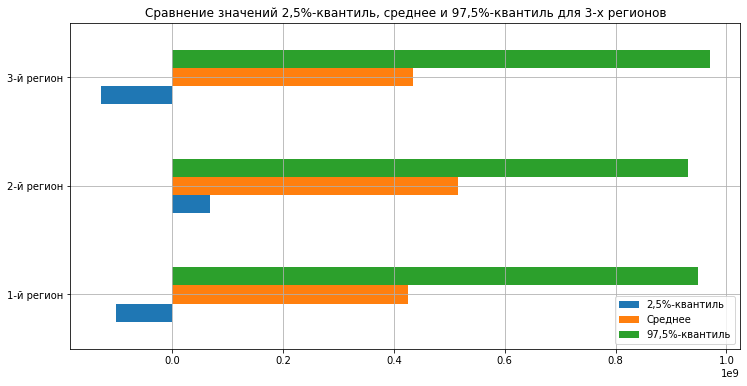

In [43]:
lower = [lower_0, lower_1, lower_2]
upper = [upper_0, upper_1, upper_2]
mean = [mean_0, mean_1, mean_2]
index = ['1-й регион', '2-й регион', '3-й регион']
df = pd.DataFrame({'2,5%-квантиль': lower,'Среднее': mean, '97,5%-квантиль': upper}, index=index)
ax = df.plot.barh(
    grid = True,
    title = 'Сравнение значений 2,5%-квантиль, среднее и 97,5%-квантиль для 3-х регионов',
    figsize=(12,6))

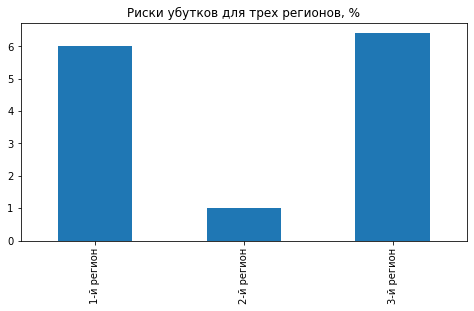

In [56]:
risk = [risk_0, risk_1, risk_2]
df = pd.DataFrame(risk, index=index)
ax = df.plot.bar(
    title = 'Риски убутков для трех регионов, %',
    legend = False,
    figsize=(8,4))

Вывод: 
- Хотя1-й и 3-й регионы имеют более широкий доверителный интервал, эти регионы имеет риск убытка на уровне 6%.
- Средняя выручка самая высокая во 2-м регионе, а также самый низкий уровень риска 1%.
- Выбираем 2-ой регион.

## Общий вывод

В ходе выполнения данного проекта были выполнены следующие действия и получены соответсвующие результаты:
1. Произведена загрузка и подготовка данных:
 - Удалены ненужные данные для модели.
 - Изучено расперделние будущего целевого признака.
2. Обучена и проверена модель для каждого региона:
 - Разбиение данных на обучающую и валидационную выборки в соотношении 75:25.
 - Обучение модели и получение предсказания на валидационной выборке.
 - Получены мледущие данные для каждого региона:
    - 1-й регион средний запас сыря : 92.59, RMSE: 37.58,
    - 2-й регион средний запас сыря : 68.73, RMSE: 0.89,
    - 3-й регион средний запас сыря : 94.97, RMSE: 40.03.
3. Расчёт прибыли (подготовка):
 - Произведен рассчет достаточного объём сырья для безубыточной разработки новой скважины, что составило 111 тыс. бар.
4. Создана функция для расчёта прибыли:
 - Создана функция для расчета максималной прибыли по заданому количеству скважин 200.
 - Произведен рассчет максимально возможной прибыли:
    - 1-й регион 3.32 млрд,
    - 2-й регион 2.42 млрд,
    - 3-й регион 2,42 млрд.
5. Роизведен расчет рисков и прибыли для каждого региона:
 - Была применена техника Bootstrap с 1000 выборок.
 - Произведен расчет средней прибыли, 95%-й доверительный интервал и риск убытков.
    - 1-й регион: средняя выручка 425 млн, есть риск убытков 6.0%, 95% довертильный интервал -102 млн - 947 млн.
    - 2-й регион: средняя выручка 515 млн, есть риск убытков 1.0%, 95% довертильный интервал   68 млн - 931 млн.
    - 3-й регион: средняя выручка 435 млн, есть риск убытков 6.4%, 95% довертильный интервал -128 млн - 969 млн.
6. Выбран 2-й регион, как регион с наибольшим средним значением прибыли и наименьшим риском понести убыток.